### Предсказание дефолта сделки, используя Logistic Regression, SVM, Random Forest Classifier, Catboost

## Оглавление
1. [Импорт библиотек](#Импорт-библиотек)
1. [Импорт датасетов](#Импорт-датасетов)
2. [EDA](#EDA)
3. [TargetEncoder колонки "Region"](#TargetEncoder-колонки-"Region")
1. [One Hot Encoding](#One-Hot-Encoding")
1. [Генерируем новые фичи](#Генерируем-новые-фичи)
1. [Удаляем незначимые для таргета колонки](#Удаляем-незначимые-для-таргета-колонки)
3. [Разделим ранее сконкатенированные датасеты](#Разделим-ранее-сконкатенированные-датасеты)
1. [Разделим датасет на трейн и тест с параметром stratify](#Разделим-датасет-на-трейн-и-тест-с-параметром-stratify")
1. [Построим базовую модель LogisticRegression в качестве бейзлайна.](#Построим-базовую-модель-LogisticRegression-в-качестве-бейзлайна)
1. [Построим пайпланы для SVM, RandomForest, Catboost](#Построим-пайпланы-для-SVM,-RandomForest,-Catboost)
1. [SVM](#SVM)
1. [RandomForest](#RandomForest)
1. [Смотрим на значимость признаков для модели](#Смотрим-на-значимость-признаков-для-модели)
1. [Catboost](#Catboost)
1. [Сохранение датасета](#Сохранение-датасета)
1. [В какую сторону можно искать улучшения?](#В-какую-сторону-можно-искать-улучшения?)

### Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import category_encoders as ce
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

### Импорт датасетов

In [31]:
df = pd.read_csv("./train.csv")
df_train = df.loc[df['Default'].notna()]
df_test = pd.read_csv("./test.csv")

Соединим test и train датасеты чтобы лучше понять распределение данных в датасетах и обработать данные.

In [32]:
df = pd.concat([df_train, df_test], ignore_index=True)

### EDA

Проверим датасет на дупликаты и пропущенные значения.

In [4]:
df['Deal_id'].duplicated().sum()

0

In [5]:
df.isnull().sum()

Deal_id                      0
Deal_date                    0
First_deal_date              0
Secret_dwarf_info_1       3482
Secret_dwarf_info_2       3482
Secret_dwarf_info_3       3482
First_default_date        3482
Successful_deals_count      15
Region                      11
Tavern                       0
Hashed_deal_detail_1         0
Hashed_deal_detail_2         0
Hashed_deal_detail_3         0
Hashed_deal_detail_4         0
Hashed_deal_detail_5         0
Hashed_deal_detail_6         0
Age                          0
Gender                       0
Default                    989
dtype: int64

Заполним пустые ячейки.

In [6]:
# посмотрим на моду колонки Region
df.Region.mode()

0    Tavern_district_3
Name: Region, dtype: object

In [7]:
# посмотрим на распределение в Secret_dwarf_info_2
df['Secret_dwarf_info_2'].value_counts()

Secret_dwarf_info_2
-2.0    314
-3.0    281
-1.0     66
 0.0      9
 1.0      3
 2.0      2
Name: count, dtype: int64

так как в столбце 'Secret_dwarf_info_2' имеется значение 0.0, заполним его отличным от всех значением 
для дальнейшего применения OHE

In [8]:
df['Secret_dwarf_info_1'].fillna(0, inplace=True)
df['Secret_dwarf_info_2'].fillna(100, inplace=True)
df['Secret_dwarf_info_3'].fillna(0, inplace=True)
df['First_default_date'].fillna('1970-01-01', inplace=True)
df['Successful_deals_count'].fillna(0, inplace=True)
df['Region'].fillna('Tavern_district_3', inplace=True)

проверим, что заполнены все ячейки

In [9]:
df.isnull().sum()

Deal_id                     0
Deal_date                   0
First_deal_date             0
Secret_dwarf_info_1         0
Secret_dwarf_info_2         0
Secret_dwarf_info_3         0
First_default_date          0
Successful_deals_count      0
Region                      0
Tavern                      0
Hashed_deal_detail_1        0
Hashed_deal_detail_2        0
Hashed_deal_detail_3        0
Hashed_deal_detail_4        0
Hashed_deal_detail_5        0
Hashed_deal_detail_6        0
Age                         0
Gender                      0
Default                   989
dtype: int64

Колонку Age отмасштабируем, такая техника часто может повысить качество модели.

In [10]:
df['Age'] = df['Age']//30

Посмотрим на распределение данных в колонке Successful_deals_count

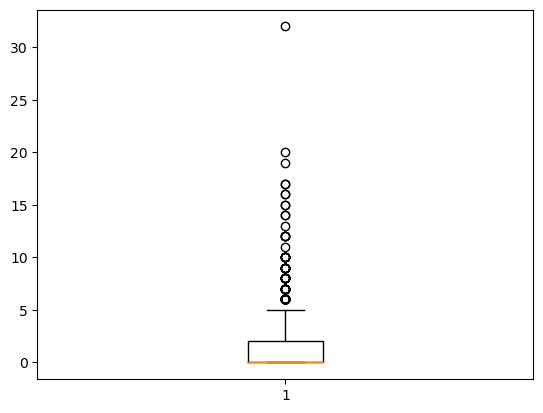

In [11]:
plt.boxplot(df['Successful_deals_count'])
plt.show()

Посмотрим на баланс классов

<BarContainer object of 2 artists>

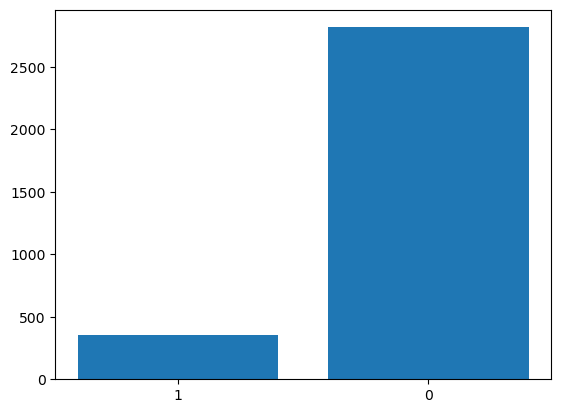

In [12]:
plt.bar(['1', '0'], [df_train['Default'].sum(), len(df_train) - df_train['Default'].sum()])

Классы не сбалансированы. Эта информация нам нужна для дальнейшего анализа и обработки данных.

Классы и колонка 'Gender' распределены примерно одинаково посмотрим, есть ли между ними корреляция. И посмотрим корреляцию колонок типа float.

In [37]:
correlation = df['Default'].corr(df['Gender'].replace(['Male', 'Female'],[1, 0]))
correlation

0.07381880909612745

In [42]:
df[['Successful_deals_count', 'Hashed_deal_detail_2', 'Hashed_deal_detail_1', 'Hashed_deal_detail_5', 'Hashed_deal_detail_6', 'Default']].corr()

,Successful_deals_count,Hashed_deal_detail_2,Hashed_deal_detail_1,Hashed_deal_detail_5,Hashed_deal_detail_6,Default
Successful_deals_count,1.000000,0.212716,0.057858,0.038686,NaN,-0.078683
Hashed_deal_detail_2,0.212716,1.000000,0.017067,0.117747,NaN,-0.016287
Hashed_deal_detail_1,0.057858,0.017067,1.000000,-0.004443,NaN,0.023913
Hashed_deal_detail_5,0.038686,0.117747,-0.004443,1.000000,NaN,0.014640
Hashed_deal_detail_6,NaN,NaN,NaN,NaN,NaN,NaN
Default,-0.078683,-0.016287,0.023913,0.014640,NaN,1.000000


Корреляции нет.

### TargetEncoder колонки "Region"

экспериментальным путем выяснили, что это лучший вариант обработки колонки это применение TargetEncoder к колонке "Region"

In [13]:
y=df['Default']
x=df['Region']

df['Region'] = ce.TargetEncoder().fit_transform(x,y)

### One Hot Encoding

Определим какие колонки мы хотим кодировать OHE

In [14]:
dummies_cols = ['Age', 'Gender']

Приведем даты к типу datetime, сгенерируем на основе них новые категориальные фичи year, month, day, weekday.

Применим OHE

In [15]:
date_cols = ['Deal_date', 'First_deal_date', 'First_default_date'] 

fddt = []    
for i in range(len(df['First_default_date'])):
    if not df['First_default_date'][i]:
        fddt.append(df['Deal_date'][i])
    else:
        fddt.append(df['First_default_date'][i])
df['First_default_date'] = fddt
    
for col in date_cols:
    df[col] = df[col].apply(pd.to_datetime)
    df[f'{col}_time'] = df[col].values.astype(np.int64) // 10 ** 9
    
    if col == 'First_default_date':
        continue

    df[f'{col}_year'] = df[col].dt.year
    dummies_cols.append(f'{col}_year')
    
    df[f'{col}_month'] = df[col].dt.month
    dummies_cols.append(f'{col}_month')
    
    if col == 'First_deal_date':
        continue
    
    df[f'{col}_weekday'] = df[col].dt.weekday
    dummies_cols.append(f'{col}_weekday')
    
df = pd.get_dummies(df, columns=dummies_cols, drop_first=True)

### Генерируем новые фичи

Сгенерируем новые фичи - разницы между датами.

In [16]:
df['Fdd-Dd'] = (df['Deal_date_time'] - df['First_deal_date_time']).astype('int64')
df['Ff'] = (df['First_default_date_time'] - df['First_deal_date_time']).astype('int64')
df['Dd-fdd'] = (df['Deal_date_time'] - df['First_default_date_time']).astype('int64')

Сгенерируем новый синтетический признак, выявлен экспериментальным путем.

In [17]:
df['hh'] = df['Hashed_deal_detail_3']* df['Hashed_deal_detail_4']

### Удаляем незначимые для таргета колонки

Колонка Hashed_deal_detail_6 имеет одно значение поэтому ее удалим

In [18]:
df['Hashed_deal_detail_6'].value_counts()

Hashed_deal_detail_6
5    4157
Name: count, dtype: int64

Удалим малозначимые колонки, которыем мы выявили методом feature_importances_ уже после обучения модели в процессе донастройки. 

In [19]:
df.drop(['Deal_id', 'Deal_date', 'First_deal_date', 'First_default_date', 'Deal_date_time', 'Tavern', 'Deal_date_year_2017',
         'Hashed_deal_detail_2', 'Hashed_deal_detail_1', 'Hashed_deal_detail_5', 'Hashed_deal_detail_6'], axis=1, inplace=True)

### Разделим ранее сконкатенированные датасеты

Отделим test датасет без таргета, который мы сконкатенировали в 1 шаге для изучения распределения данных.

In [20]:
test_df = df.loc[df['Default'].isna()]

df = df.loc[df['Default'].notna()]

### Разделим датасет на трейн и тест с параметром stratify

Разделим датасет на трейн и тест используя stratify для балансировки классов.

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['Default']
)

Убедимся, что распределение таргета в датасетах одинаковое.

In [22]:
train_shares = df_train["Default"].value_counts() / df_train.shape[0]
test_shares = df_test["Default"].value_counts() / df_test.shape[0]

to_compare = pd.concat((train_shares, test_shares), axis=1)
to_compare.columns = ['Доля в трейне', 'Доля в тесте']
to_compare['Абсолютная разница'] = (to_compare["Доля в трейне"] - \
                                    to_compare["Доля в тесте"]).abs()

to_compare

,Доля в трейне,Доля в тесте,Абсолютная разница
Default,,,
0.0,0.889108,0.88959,0.000482
1.0,0.110892,0.11041,0.000482


### Построим базовую модель LogisticRegression в качестве бейзлайна. 

In [23]:
pipeline_lr = Pipeline(
    [
        ('stc', StandardScaler()),
        ('lr', LogisticRegression(random_state=100))
    ]
)

pipeline_lr.fit(df_train.drop('Default', axis=1), df_train['Default'])

train_preds = pipeline_lr.predict(df_train.drop('Default', axis=1)) 
train_accuracy = np.mean(train_preds == df_train['Default'].values)

test_preds = pipeline_lr.predict(df_test.drop('Default', axis=1)) 
test_accuracy = np.mean(test_preds == df_test['Default'].values)

print(f"Accuracy на тренировочной выборке составило {np.round(train_accuracy, decimals=3)}")
print(f"Accuracy на тестовой выборке составило {np.round(test_accuracy, decimals=3)}")

Accuracy на тренировочной выборке составило 0.891
Accuracy на тестовой выборке составило 0.888


### Построим пайпланы для SVM, RandomForest, Catboost

Построим пайплайны с тремя предложенными к рассмотрению моделями

In [24]:
pipeline_svm = Pipeline(
    [
        ('stc', StandardScaler()),
        ('SVC', SVC())
    ]
)

pipeline_rf = Pipeline(
    [
        ('stc', StandardScaler()),
        ('RF', RandomForestClassifier(random_state=100))
    ]
)

pipeline_cat = Pipeline(
    [
        ('CAT', CatBoostClassifier(verbose=False))
    ]
)

### SVM

In [25]:
svm_parameters_grid = {
    'SVC__C': [1, 0.5, 3],
    'SVC__kernel': ['linear', 'rbf', 'sigmoid']
}

search_svm = GridSearchCV(
    pipeline_svm,
    svm_parameters_grid,
    scoring="accuracy",
    return_train_score=True
)

search_svm.fit(df_train.drop('Default', axis=1), df_train['Default'])

pipeline_svm.set_params(**search_svm.best_params_)

pipeline_svm.fit(df_train.drop('Default', axis=1), df_train['Default'])

train_preds = pipeline_svm.predict(df_train.drop('Default', axis=1)) 
train_accuracy = np.mean(train_preds == df_train['Default'].values)

test_preds = pipeline_svm.predict(df_test.drop('Default', axis=1)) 
test_accuracy = np.mean(test_preds == df_test['Default'].values)

print(f"Accuracy на тренировочной выборке составило {np.round(train_accuracy, decimals=3)}")
print(f"Accuracy на тестовой выборке составило {np.round(test_accuracy, decimals=3)}")

with open('svm_model.pkl', 'wb') as f:
     pickle.dump(pipeline_svm, f)

Accuracy на тренировочной выборке составило 0.889
Accuracy на тестовой выборке составило 0.89


### RandomForest

In [26]:
rf_parameters_grid = {
    'RF__n_estimators': [100, 200, 300],
    'RF__max_depth': [10, 20, 30]
}

search_rf = GridSearchCV(
    pipeline_rf,
    rf_parameters_grid,
    scoring="accuracy",
    return_train_score=True
)

search_rf.fit(df_train.drop('Default', axis=1), df_train['Default'])

pipeline_rf.set_params(**search_rf.best_params_)

pipeline_rf.fit(df_train.drop('Default', axis=1), df_train['Default'])

train_preds = pipeline_rf.predict(df_train.drop('Default', axis=1)) 
train_accuracy = np.mean(train_preds == df_train['Default'].values)

test_preds = pipeline_rf.predict(df_test.drop('Default', axis=1)) 
test_accuracy = np.mean(test_preds == df_test['Default'].values)

print(f"Accuracy на тренировочной выборке составило {np.round(train_accuracy, decimals=3)}")
print(f"Accuracy на тестовой выборке составило {np.round(test_accuracy, decimals=3)}")

with open('rf_model.pkl', 'wb') as f:
     pickle.dump(pipeline_rf, f)

Accuracy на тренировочной выборке составило 0.924
Accuracy на тестовой выборке составило 0.891


Случайный лес справляется лучше на трейне и так же на тесте, но на тестовом датасете он все же показал лучший результат и был выбран.

### Смотрим на значимость признаков для модели

Посмотрим на значимость признаков для модели, потом используя эти данные пересоберем датасет и переобучим модель

In [27]:
feature_scores = pd.Series(pipeline_rf.steps[1][1].feature_importances_, index=df_train.drop('Default', axis=1).columns).sort_values(ascending=False)
feature_scores

Dd-fdd                       0.113153
Fdd-Dd                       0.110403
Ff                           0.097590
First_deal_date_time         0.089380
hh                           0.053473
Region                       0.048122
Hashed_deal_detail_3         0.042746
First_default_date_time      0.037235
Successful_deals_count       0.029854
Secret_dwarf_info_1          0.024884
Age_1.0                      0.023988
Secret_dwarf_info_2          0.022712
Deal_date_weekday_2          0.022286
Gender_Male                  0.021609
Hashed_deal_detail_4         0.017603
Secret_dwarf_info_3          0.014372
Deal_date_weekday_6          0.013137
Deal_date_month_5            0.012396
Deal_date_weekday_4          0.011563
Deal_date_weekday_1          0.010497
Deal_date_weekday_3          0.010296
Deal_date_weekday_5          0.009787
Deal_date_month_4            0.009570
First_deal_date_month_7      0.009089
Deal_date_year_2016          0.008983
First_deal_date_month_4      0.008812
Deal_date_mo

### Catboost

In [28]:
cat_parameters_grid = {
    'CAT__n_estimators': [50, 100, 20],
    'CAT__max_depth': [5, 10, 30]
}

search_cat = GridSearchCV(
    pipeline_cat,
    cat_parameters_grid,
    scoring="accuracy",
    return_train_score=True
)

search_cat.fit(df_train.drop('Default', axis=1), df_train['Default'])

pipeline_cat.set_params(**search_cat.best_params_)

pipeline_cat.fit(df_train.drop('Default', axis=1), df_train['Default'])

train_preds = pipeline_cat.predict(df_train.drop('Default', axis=1)) 
train_accuracy = np.mean(train_preds == df_train['Default'].values)

test_preds = pipeline_cat.predict(df_test.drop('Default', axis=1)) 
test_accuracy = np.mean(test_preds == df_test['Default'].values)

print(f"Accuracy на тренировочной выборке составило {np.round(train_accuracy, decimals=3)}")
print(f"Accuracy на тестовой выборке составило {np.round(test_accuracy, decimals=3)}")

with open('cat_model.pkl', 'wb') as f:
     pickle.dump(pipeline_cat, f)

Accuracy на тренировочной выборке составило 0.923
Accuracy на тестовой выборке составило 0.886


### Сохранение датасета

In [29]:
preds = pipeline_rf.predict_proba(test_df.drop(['Default'], axis=1))[:, 1]
test_df['Prediction'] = preds

test_df['Prediction'].to_csv('prediction.csv', index=False)

### В какую сторону можно искать улучшения?

Во-первых, необходимо лучше отобрать признаки, применив стратегии отбора: Forward selection, Backward selection, RFE.

Во-вторых, можно продолжить эксперименты с моделями и посмотреть побольше в сторону ансамблей.

В-третьих, можно проанализировать данные на выбросы и провести очистку.

Наконец, есть множество других способов классификации: нейросетевой подход, LDA, etc.